In [11]:
import xarray
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mticker
import matplotlib
from matplotlib.ticker import LogFormatter,LogLocator
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import AxesGrid
import cartopy.crs as ccrs
import numpy as np
import glob
import os
from tqdm.autonotebook import tqdm
import warnings
from datetime import date, datetime, timedelta
warnings.simplefilter('ignore')

In [12]:
def loader(path):
    paths = glob.glob(path)
    paths.sort(key=os.path.getmtime)
    file = xarray.open_mfdataset(paths, combine='by_coords')
    return file

In [13]:
hs_file = loader('/Volumes/JCHD/Microplastics_Paper/Data/Hs_24hr/*.nc')
#tau_file = loader('/Volumes/JCHD/Microplastics_Paper/Data/Surface_wind_stress_24hr/SWS*.nc')

In [20]:
start = datetime(2002,1,1)
end = datetime(2011,9,30)
delta = timedelta(days=1)

In [21]:
dates = []
current = start
dates.append(current.strftime('%Y%m%d'))
while current < end:
    current += delta
    dates.append(current.strftime('%Y%m%d'))

In [22]:
tau_1 = loader('/Volumes/JCHD/Microplastics_Paper/Data/Surface_wind_stress_24hr/SWS20020101.nc')
tau = (((tau_1.taux**2)+(tau_1.tauy**2))**0.5)[:,47:680:2,0::2].values

In [25]:
for i in tqdm(range(len(dates))):
    i + 1
    path = '/Volumes/JCHD/Microplastics_Paper/Data/Surface_wind_stress_24hr/SWS' + dates[i] + '.nc'
    tau_file = loader(path)
    tau_np = (((tau_file.taux**2)+(tau_file.tauy**2))**0.5)[:,47:680:2,0::2].values
    tau = np.concatenate((tau,tau_np))

In [26]:
print(tau.shape)

(3566, 317, 720)


In [27]:
hs = hs_file.Hs.values

In [28]:
print(hs.shape)

(4748, 317, 720)


In [29]:
hs = hs[:3566,:,:]

In [30]:
print(hs.shape)

(3566, 317, 720)


In [31]:
tau_2 = tau[:,:,:360]
tau_1 = tau[:,:,360:]
tau = np.concatenate((tau_1,tau_2),axis=2)

In [32]:
Az = 0.30 * 0.41 * 0.85 * hs * (tau/1025)**0.5

In [34]:
dims = ('time', 'latitude', 'longitude')

Az_file = xarray.Dataset(
        data_vars={
                'Az': (dims, Az)},
        coords={
                'time': hs_file.time[:3566],
                'latitude': hs_file.latitude,
                'longitude': hs_file.longitude}
    )

Az_mean = Az_file.Az.mean('time')

In [37]:
Az_mean.to_netcdf('/Volumes/JCHD/Microplastics_Paper/Data/Viscosity_Model_10_year_average.nc')

In [35]:
#tau = Az_mean.values
#lons = Az_mean.longitude.values
#lats = Az_mean.latitude.values

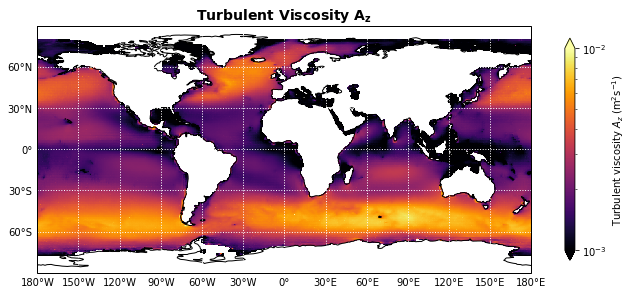

In [36]:
fig = plt.figure(figsize=(12,10))

ax1 = plt.subplot(211, projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.set_extent([-179.9, 179.9, -90, 90], ccrs.PlateCarree())
Az_mean.plot(ax=ax1, transform=ccrs.PlateCarree(),norm=colors.LogNorm(vmin=0.001, vmax=0.01),cbar_kwargs=dict(shrink=0.9, label=r'Turbulent viscosity $A_{z}$ (m$^{2}$s$^{-1}$)'), cmap='inferno')
plt.title(r'Turbulent Viscosity $\bf{A_{z}}$',fontweight="bold",fontsize=14)
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='white', alpha=1, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xlocator = mticker.FixedLocator([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

#ax2 = plt.subplot(212)
#y = np.nanmean(Az_mean.values,axis=1)
#x = Az_mean.latitude.values
#plt.plot(x,y)